<a href="https://colab.research.google.com/github/mfavaits/YouTube-Series-on-Machine-Learning/blob/master/Transfer_Learning_ResNet50_with_Dropout_100_Epochs_Dogs_vs_Cats_Small_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt

import os
import shutil

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from keras.applications import ResNet50
from keras.preprocessing.image import ImageDataGenerator
conv_base = ResNet50(weights= 'imagenet', include_top=False, input_shape=(150,150,3))
conv_base.summary ()

Using TensorFlow backend.


/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 75, 75, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

The final feature map has shape (5, 5, 2048).
We extract features from by calling the predict method on the conv_base model

In [0]:
datagen=ImageDataGenerator(rescale=1./255)
batch_size=20

In [0]:
def extract_features(directory, sample_count): #extract features from a directory with JPEG files and sample_count is # files in dir
    features=np.zeros(shape=(sample_count, 5, 5, 2048)) # empty array
    labels=np.zeros(shape=(sample_count)) # empty array
    generator=datagen.flow_from_directory(directory, target_size=(150, 150), batch_size=20, class_mode='binary')
    
    i=0
    for inputs_batch, labels_batch in generator: 
      features_batch=conv_base.predict(inputs_batch) # extract features from conv_base
      features[i*batch_size:(i+1)*batch_size]=features_batch # for i=0 we have features[0:20], for i=2 features[20:40]
      labels[i*batch_size:(i+1)*batch_size]=labels_batch
      i+=1
      if i*batch_size>=sample_count:
        break #break when every image has been seen once
    return features, labels

In [13]:
train_features, train_labels = extract_features('/content/drive/My Drive/Colab Notebooks/training_2000', 2000)
validation_features, validation_labels = extract_features('/content/drive/My Drive/Colab Notebooks/val_1000', 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


The extracted features are currently of shape (samples, 5 , 5, 2048) and we need to flatten before pushing them through a densely connected layer

In [0]:
train_features=np.reshape(train_features, (2000, 5*5*2048))
validation_features=np.reshape(validation_features, (1000, 5*5*2048))

In [15]:
from keras import models
from keras import layers
from keras import optimizers

model=models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=5*5*2048))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [16]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [17]:
history = model.fit(train_features, train_labels, epochs=100, batch_size=20, validation_data=(validation_features, validation_labels))



Train on 2000 samples, validate on 1000 samples
Epoch 1/100
2000/2000 [==============================] - 19s 9ms/step - loss: 0.7451 - acc: 0.5400 - val_loss: 0.6980 - val_acc: 0.5190
Epoch 2/100
2000/2000 [==============================] - 17s 9ms/step - loss: 0.6894 - acc: 0.5550 - val_loss: 0.6937 - val_acc: 0.5010
Epoch 3/100
2000/2000 [==============================] - 17s 9ms/step - loss: 0.6736 - acc: 0.5820 - val_loss: 0.6600 - val_acc: 0.6030
Epoch 4/100
2000/2000 [==============================] - 17s 9ms/step - loss: 0.6721 - acc: 0.5805 - val_loss: 0.6497 - val_acc: 0.6240
Epoch 5/100
2000/2000 [==============================] - 17s 9ms/step - loss: 0.6605 - acc: 0.5965 - val_loss: 0.6422 - val_acc: 0.6410
Epoch 6/100
2000/2000 [==============================] - 17s 9ms/step - loss: 0.6574 - acc: 0.6000 - val_loss: 0.6496 - val_acc: 0.6140
Epoch 7/100
2000/2000 [==============================] - 17s 9ms/step - loss: 0.6600 - acc: 0.5925 - val_loss: 0.6430 - val_acc: 0.606

In [0]:
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

In [0]:
epochs=range(1, len(acc)+1)

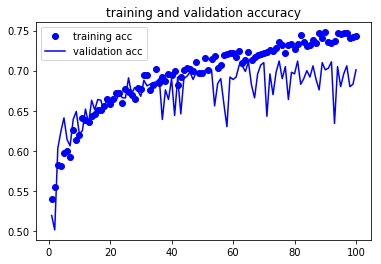

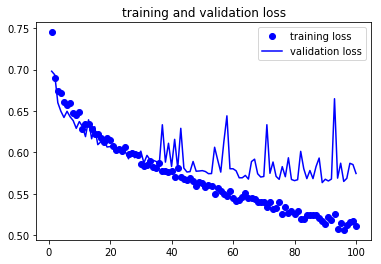

In [20]:
plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()